In [1]:
import time


In [2]:
def normalize(A):
    return (A - A.min()) / (A.max() - A.min())

In [3]:
from matplotlib import pyplot as plt 
import numpy as np
from matplotlib.font_manager import FontProperties
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d
from skimage.io import imread

font_path = font_path = "/usr/share/fonts/truetype/migmix/migmix-1p-regular.ttf"
font_prop = FontProperties(fname=font_path)
plt.rc('font',family=font_prop.get_name())

def get_psnr(im, recon):
    """ PSNRを得る """ 
    return 10. * np.log(im.max() / np.sqrt(np.mean((im - recon) ** 2)))

def show_dictionary(A, name=None, figsize=(4, 4), vmin=None, vmax=None):
    """ 辞書を表示 """
    n = int(np.sqrt(A.shape[0]))
    m = int(np.sqrt(A.shape[1]))
    A_show = A.reshape((n, n, m, m))
    fig, ax = plt.subplots(m, m, figsize=figsize)
    for row in range(m):
        for col in range(m):
            ax[row, col].imshow(A_show[:, :, col, row], cmap='gray', interpolation='Nearest', vmin=vmin, vmax=vmax)
            ax[row, col].axis('off')
    if name is not None:
        plt.savefig(name, dpi=220)
        
def OMP(A, b, k0, eps):
    """ 
    直交マッチング追跡(orthogonal matching pursuit; OMP) 
    
    A nxm行列
    b n要素の観測
    k0 xの非ゼロの要素数
    eps 誤差の閾値
    
    戻り値
    x m要素のスパース表現
    S m要素のサポートベクトル
    """
    # 初期化
    x = np.zeros(A.shape[1])
    S = np.zeros(A.shape[1], dtype=np.uint8)
    r = b.copy()
    rr = np.dot(r, r)
    for _ in range(k0):
        # 誤差計算
        err = rr - np.dot(A[:, S == 0].T, r) ** 2
            
        # サポート更新
        ndx = np.where(S == 0)[0]
        S[ndx[err.argmin()]] = 1
    
        # 解更新
        As = A[:, S == 1]
        pinv = np.linalg.pinv(np.dot(As, As.T))
        x[S == 1] = np.dot(As.T, np.dot(pinv, b))
        
        # 残差更新
        r = b - np.dot(A, x)
        rr = np.dot(r, r)
        if rr < eps:
            break
            
    return x, S

/home/alien/.local/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


Peppers
---

In [4]:
import skimage 

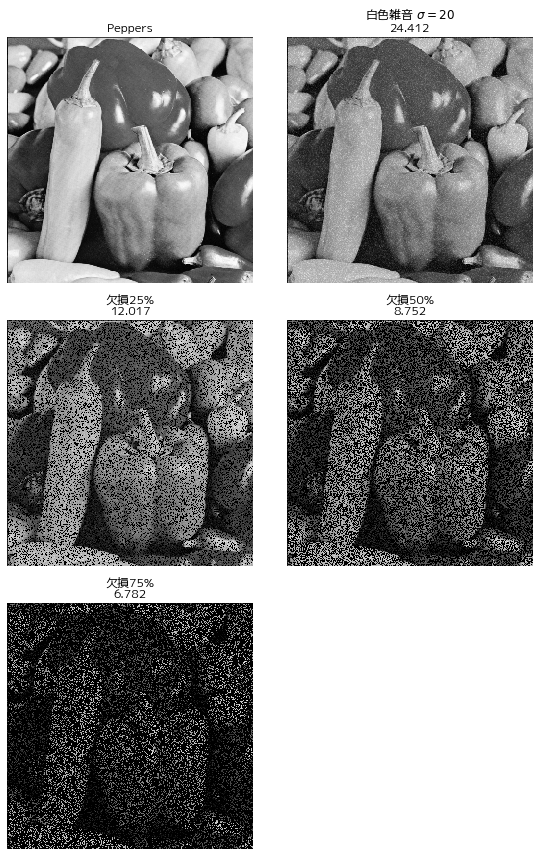

In [5]:
start = time.time()
im = skimage.color.rgb2gray(imread('../sparse-modeling/peppers.png'))[::2, ::2] * 255
sig = 20.

if np.any(im < 0): print('im is Nonnegative')

if True:
    Y = im + np.abs(np.random.randn(im.shape[0], im.shape[1])) * sig
    mask = abs(np.random.rand(im.shape[0], im.shape[1]))
    mask_25 = mask > 0.25
    mask_50 = mask > 0.5
    mask_75 = mask > 0.75
    Y_25 = Y * mask_25
    Y_50 = Y * mask_50
    Y_75 = Y * mask_75
    Y.tofile('Peppers_Y_sig20')
    Y_25.tofile('Peppers_Y_sig20_25')
    Y_50.tofile('Peppers_Y_sig20_50')
    Y_75.tofile('Peppers_Y_sig20_75')
    mask.tofile('mask')
    mask_25.tofile('mask_25')
    mask_50.tofile('mask_50')
    mask_75.tofile('mask_75')
else:
    print('Here')
    Y = np.fromfile('Peppers_Y_sig20').reshape(im.shape)
    Y_25 = np.fromfile('Peppers_Y_sig20_25').reshape(im.shape)
    Y_50 = np.fromfile('Peppers_Y_sig20_50').reshape(im.shape)
    Y_75 = np.fromfile('Peppers_Y_sig20_75').reshape(im.shape)
    mask = np.fromfile('mask').reshape(im.shape)
    mask_25 = np.fromfile('mask_25', dtype=np.uint8).reshape(im.shape)
    mask_50 = np.fromfile('mask_50', dtype=np.uint8).reshape(im.shape)
    mask_75 = np.fromfile('mask_75', dtype=np.uint8).reshape(im.shape)

if np.any(Y < 0): print('Y is nonnegative')

fig, ax = plt.subplots(3, 2, figsize=(8, 12))
ax = ax.flatten()
ax[0].imshow(im, cmap='gray', interpolation='Nearest')
ax[1].imshow(Y, cmap='gray', interpolation='Nearest')
ax[2].imshow(Y_25, cmap='gray', interpolation='Nearest')
ax[3].imshow(Y_50, cmap='gray', interpolation='Nearest')
ax[4].imshow(Y_75, cmap='gray', interpolation='Nearest')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[3].axis('off')
ax[4].axis('off')
ax[0].set_title('Peppers')
ax[1].set_title('白色雑音 '+r'$\sigma = 20$'+'\n{:.3f}'.format(get_psnr(im, Y)))
ax[2].set_title('欠損25%\n{:.3f}'.format(get_psnr(im, Y_25)))
ax[3].set_title('欠損50%\n{:.3f}'.format(get_psnr(im, Y_50)))
ax[4].set_title('欠損75%\n{:.3f}'.format(get_psnr(im, Y_75)))
ax[-1].axis('off')
plt.tight_layout()
plt.savefig('Peppers_inpaint.png', dpi=220)

冗長DCT辞書
--

In [6]:
patch_size = 8
dict_size = 16
A_1D = np.zeros((patch_size, dict_size))
for k in np.arange(dict_size):
    for i in np.arange(patch_size):
        A_1D[i, k] = np.cos(i * k * np.pi / float(dict_size))
    if k != 0:
        A_1D[:, k] -= A_1D[:, k].mean()

A_DCT = np.kron(A_1D, A_1D)
A_DCT_norm = normalize(A_DCT)
A_DCT.tofile('A_DCT')
A_DCT_norm.tofile('A_DCT_norm')

TypeError: cannot unpack non-iterable NoneType object

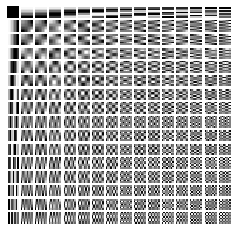

In [7]:
A_DCT = np.fromfile('A_DCT').reshape((patch_size ** 2, dict_size ** 2))
fig, ax = show_dictionary(A_DCT)


In [ ]:
A_DCT_norm = np.fromfile('A_DCT_norm').reshape((patch_size ** 2, dict_size ** 2))
show_dictionary(A_DCT_norm)

In [22]:
A_DCT_norm

array([[0.87051326, 0.60971493, 0.82374659, ..., 0.82067357, 0.80530134,
        0.82954045],
       [0.87051326, 0.60252606, 0.79526738, ..., 0.17406756, 0.12606972,
        0.13021809],
       [0.87051326, 0.58123572, 0.71416546, ..., 0.60272804, 0.70189449,
        0.80266589],
       ...,
       [0.87051326, 0.44343892, 0.30643857, ..., 0.41178021, 0.47213959,
        0.55394273],
       [0.87051326, 0.3787562 , 0.18506097, ..., 0.59095218, 0.57465624,
        0.46568114],
       [0.87051326, 0.30857136, 0.10395905, ..., 0.45178022, 0.42122923,
        0.52003236]])

マスク付き辞書学習の解法
--

In [24]:
class DctionaryLearning(object):    
    """ 辞書学習 """
    def NSR(self, Y, sig, m, alpha=0.001, n_iter=50, A0=None, initial_dictionary=None, mask=None):
        if initial_dictionary is None:
            A = Y[:, :m]
            A = np.dot(A, np.diag(1. / np.sqrt(np.diag(np.dot(A.T, A)))))

        else:
            A = initial_dictionary.copy()

        X = np.random.ranf(A.shape[1]*Y.shape[1]).reshape(A.shape[1], Y.shape[1])
        eps = A.shape[0] * (sig ** 2)

        ndx = np.arange(m)
        log = []

        
        
        for k in range(n_iter):
            
            """
            if mask is None:
                for i in range(Y.shape[1]):
                    X[:, i], _ = OMP(A, Y[:, i], k0, eps=eps)
            else:
                # マスクあり
                for i in range(Y.shape[1]):
                    A_mask = A[mask[:, i] == 1, :]
                    Y_mask = Y[mask[:, i] == 1, i]
                    eps = len(Y_mask) * (sig ** 2) * 1.1
                    X[:, i], _ = OMP(A_mask, Y_mask, k0, eps=eps)
                    Y[mask[:, i] == 0, i] = np.dot(A[mask[:, i] == 0, :], X[:, i])
            """
            if np.any(A < 0):
                print('Nonnegative A:', A)
            if np.any(X < 0):
                print('Nonnegative X:', X)
            
            eta = 0.1
            A_bunsi = Y @ X.T
            A_bunbo = A @ (X @ X.T)
            """
            if k == 0:
                print('A:', A)
                print('multiply:', A_bunsi / A_bunbo)
                print('bunsi', A_bunsi)
                print('bunbo', A_bunbo)
            """
            A = A * (A_bunsi / A_bunbo)
            A = normalize(A)
            X_bunsi = A.T @ Y
            X_bunbo = (A.T @ A) @ X
            X = X * (X_bunsi / X_bunbo)
            

            A[A < 1e-7] = 1e-7
            X[X < 1e-7] = 1e-7
            
            
            
            opt = np.abs(Y - np.dot(A, X)).mean()
            print(k, opt)
        return A, np.array(log)
    
    def MOD(self, Y, sig, m, k0, n_iter=50, A0=None, initial_dictionary=None):
        """ 
        MOD辞書学習アルゴリズム 
        
        Y 信号事例、n×M、nは事例の次元、Mは事例の総数
        sig ノイズレベル
        m 辞書の列数
        k0 非ゼロ要素の個数
        """
        if initial_dictionary is None:
            A = Y[:, :m]
            A = np.dot(A, np.diag(1. / np.sqrt(np.diag(np.dot(A.T, A)))))
        else:
            A = initial_dictionary
        X = np.zeros((A.shape[1], Y.shape[1]))
        eps = A.shape[0] * (sig ** 2)

        log = []
        for k in range(n_iter):
            for i in range(Y.shape[1]):
                X[:, i], _ = OMP(A, Y[:, i], k0, eps=eps)

            opt = np.abs(Y - np.dot(A, X)).mean()
            
            A = np.dot(Y, np.dot(X.T, np.linalg.pinv(np.dot(X, X.T))))
            A = np.dot(A, np.diag(1. / np.sqrt(np.diag(np.dot(A.T, A)))))
            
            if A0 is not None:
                opt2 = self.percent_recovery_of_atoms(A, A0)
                log.append((opt, opt2))
            else:
                log.append(opt)            
            print(k, log[k])

        return A, np.array(log)
    
    def KSVD(self, Y, sig, m, k0, n_iter=50, A0=None, initial_dictionary=None, mask=None):
        """ 
        K-SVD辞書学習アルゴリズム
        
        Y 信号事例、n×M、nは信号の次元、Mは事例の総数
        sig ノイズレベル
        m 辞書の列数
        k0 非ゼロ要素の個数

        参考
        https://github.com/greyhill/pypbip/blob/master/ksvd.py
        """
        if initial_dictionary is None:
            A = Y[:, :m]
            A = np.dot(A, np.diag(1. / np.sqrt(np.diag(np.dot(A.T, A)))))
        else:
            A = initial_dictionary.copy()
        X = np.zeros((A.shape[1], Y.shape[1]))
        eps = A.shape[0] * (sig ** 2)

        ndx = np.arange(m)
        log = []
        for k in range(n_iter):
            if mask is None:
                for i in range(Y.shape[1]):
                    X[:, i], _ = OMP(A, Y[:, i], k0, eps=eps)
            else:
                # マスクあり
                for i in range(Y.shape[1]):
                    A_mask = A[mask[:, i] == 1, :]
                    Y_mask = Y[mask[:, i] == 1, i]
                    eps = len(Y_mask) * (sig ** 2) * 1.1
                    X[:, i], _ = OMP(A_mask, Y_mask, k0, eps=eps)
                    Y[mask[:, i] == 0, i] = np.dot(A[mask[:, i] == 0, :], X[:, i])
                    
            for j in ndx:      
                x_using = X[j, :] != 0
                if np.sum(x_using) == 0:
                    continue
                X[j, x_using] = 0
                Residual_err = Y[:, x_using] - np.dot(A, X[:, x_using])                 
                U, s, Vt = np.linalg.svd(Residual_err)
                A[:, j] = U[:, 0]
                X[j, x_using] = s[0] * Vt.T[:, 0]

            opt = np.abs(Y - np.dot(A, X)).mean()
            if A0 is not None:
                opt2 = self.percent_recovery_of_atoms(A, A0)
                log.append((opt, opt2))
            else:
                log.append(opt)            
            print(k, log[k])

        return A, np.array(log)

    def percent_recovery_of_atoms(self, A, A0, threshold=0.99):
        """ アトムの復元率を測る """
        num = 0
        for m in range(A.shape[1]):
            a = A0[:, m]
            if np.abs(np.dot(a, A)).max() > threshold:
                num += 1
        return float(num) / A.shape[1] * 100

In [9]:
def dictionary_learning_with_mask(im, mask, A_DCT, patch_size=8, n_iter=15):
    """ マスク付き辞書学習を実行 """
    dl = DctionaryLearning()
    patches = extract_patches_2d(im, (patch_size, patch_size)).reshape((-1, patch_size ** 2))
    mask_patches = extract_patches_2d(mask, (patch_size, patch_size)).reshape((-1, patch_size ** 2))
    M = len(patches)
    print(M)
    
    A_KSVD = A_DCT.copy()
    for _ in range(n_iter):
        ndx = np.random.permutation(M)[:A_DCT.shape[1] * 50]
        #A_KSVD, _ = dl.KSVD(patches[ndx].T, 20., 256, 4, mask=mask_patches[ndx].T, n_iter=1, initial_dictionary=A_KSVD)
        A_KSVD, _ = dl.KSVD(patches[ndx].T, 20., 256, 4,  mask=None, n_iter=1, initial_dictionary=A_KSVD)

    return A_KSVD

In [26]:
def dictionary_learning_with_mask2(im, mask, A_DCT, patch_size=8, n_iter=15):
    """ マスク付き辞書学習を実行 """
    dl = DctionaryLearning()
    patches = extract_patches_2d(im, (patch_size, patch_size)).reshape((-1, patch_size ** 2))
    mask_patches = extract_patches_2d(mask, (patch_size, patch_size)).reshape((-1, patch_size ** 2))
    M = len(patches)
    print(M)
    
    A_KSVD = A_DCT.copy()
    print('n_iter dl with mask2:', n_iter)
    for _ in range(n_iter):
        ndx = np.random.permutation(M)[:A_DCT.shape[1] * 50]
        A_KSVD, _ = dl.NSR(patches[ndx].T, 20., 256, alpha=0, mask=mask_patches[ndx].T, n_iter=10, initial_dictionary=A_KSVD)

    return A_KSVD

In [30]:
#%debug
A_KSVD_25_normDCT = dictionary_learning_with_mask(Y_25, mask_25, A_DCT_norm)
A_KSVD_25_normDCT.tofile('A_KSVD_25_normDCT')

62001
0 41.69484333381733
0 42.17072245854636
0 41.81596505217769
0 39.46171691597803
0 39.283396261385434
0 39.07103927023354
0 38.904095929136524
0 38.69262402377666
0 38.55345959156312
0 38.45288084307356
0 38.37258218743597
0 38.23298609456306
0 37.99110846273685
0 38.097208578342496
0 38.01195305542719


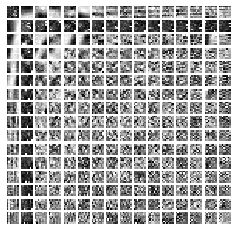

In [31]:
A_KSVD_25_normDCT = np.fromfile('A_KSVD_25_normDCT').reshape((patch_size ** 2, dict_size ** 2))
show_dictionary(A_KSVD_25_normDCT, name='A_KSVD_25_normDCT.png')

In [32]:
#%debug
A_KSVD_25_normDCT_normY = dictionary_learning_with_mask(normalize(Y_25), mask_25, A_DCT_norm)
A_KSVD_25_normDCT_normY.tofile('A_KSVD_25_normDCT_normY')

62001
0 0.18491155736171871
0 0.16816019399132595
0 0.17559758647621082
0 0.18598753374418395
0 0.16201864442129937
0 0.15931987289549718
0 0.1581138375175918
0 0.1577482715808112
0 0.156995624977334
0 0.15683808143783573
0 0.15678767512071082
0 0.15717914940913835
0 0.15598255094272254
0 0.15566464214494594
0 0.15545419556940102


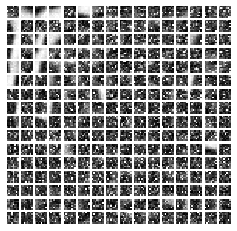

In [33]:
A_KSVD_25_normDCT_normY = np.fromfile('A_KSVD_25_normDCT_normY').reshape((patch_size ** 2, dict_size ** 2))
show_dictionary(A_KSVD_25_normDCT_normY, name='A_KSVD_25_normDCT_normY.png')

In [34]:
A_NSR_25 = dictionary_learning_with_mask2(normalize(Y_25), mask_25, A_DCT_norm, n_iter=5)
A_NSR_25.tofile('A_NSR_25')

62001
n_iter dl with mask2: 5
0 0.18218078707509514
1 0.1815931969093593
2 0.1810279445030878
3 0.18043016277267987
4 0.17978320929404543
5 0.1790677646087467
6 0.1782602803764823
7 0.1773322464855735
8 0.17625222983924707
9 0.1749940014177434
0 0.1818745937905747
1 0.18094806816997522
2 0.1800250201291674
3 0.17902360875664378
4 0.17790409483150404
5 0.17662950658436594
6 0.17517989810464346
7 0.17356212495705603
8 0.1718028126690583
9 0.1699234106629577
0 0.1823595620847689
1 0.18081432364569075
2 0.1792297690851611
3 0.17750697587748515
4 0.1756168026286442
5 0.17356633267307991
6 0.17138275365246539
7 0.16908219113266912
8 0.16666187289622042
9 0.16410144779991703
0 0.18102849732949264
1 0.1783916952076173
2 0.17570639330124102
3 0.17287006465308155
4 0.1698849132759836
5 0.16676817007159286
6 0.16351309230011757
7 0.16010024828904684
8 0.15651394283580042
9 0.15275528531160587
0 0.1781293862572655
1 0.17339381755566102
2 0.16866788004838434
3 0.16381069894348768
4 0.15881233515964

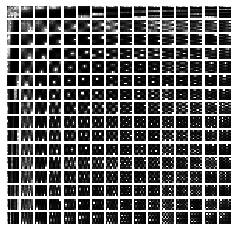

In [35]:
show_dictionary(A_NSR_25, name='A_NSR_
                
                
                
                25.png')

マスク付きスパース符号化
--

In [ ]:
def sparse_coding_with_mask(im, A, k0, sig, mask, patch_size=8):
    """ マスク付きスパース符号化 """        
    patches = extract_patches_2d(im, (patch_size, patch_size))
    mask_patches = extract_patches_2d(mask, (patch_size, patch_size))
    q = np.zeros((len(patches), A.shape[1]))
    for i, (patch, mask_patch) in enumerate(zip(patches, mask_patches)):
        if i % 1000 == 0:
            print(i)
        A_mask = A[mask_patch.flatten() == 1, :]
        patch_mask = patch[mask_patch == 1]
        eps = len(patch_mask) * (sig ** 2) * 1.1
        q[i], _ = OMP(A_mask, patch_mask, k0, eps=eps)
    return q

def recon_image(im, q, A, lam=0.5, patch_size=8):
    """ 画像の再構成 """
    recon_patches = (np.dot(A, q.T).T).reshape((-1, patch_size, patch_size))
    recon = reconstruct_from_patches_2d(recon_patches, im.shape)
    return (im * lam + recon) / (lam + 1.)

In [ ]:
q_25_KSVD_normDCT = sparse_coding_with_mask(Y_25, A_KSVD_25_normDCT, 4, sig, mask_25)
q_25_KSVD_normDCT.tofile('Peppers_q_25_KSVD')

In [ ]:
A_KSVD_25_normDCT = np.fromfile('A_KSVD_25').reshape((patch_size ** 2, dict_size ** 2))
q_25_KSVD_normDCT = np.fromfile('Peppers_q_25_KSVD').reshape((-1, dict_size ** 2))
Y_25_recon_KSVD_normDCT = recon_image(Y_25, q_25_KSVD_normDCT, A_KSVD_25_normDCT, lam=0)
Y_25_recon_KSVD_normDCT.tofile('Peppers_recon_Y_sig20_25_KSVD')